In [117]:
# ## install finrl library
# !pip install wrds
# !pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/flpymonkey/FinRL-Fork.git

In [118]:
import warnings
warnings.filterwarnings("ignore")

In [119]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

In [120]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [121]:
# TODO, remove DOW from training as it is missing some values in 2019
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [122]:
TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2020-12-31'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-01-01'

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import DOW_30_TICKER


# TODO Drop the DOW stock
value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
print(DOW_30_TICKER)

TIME_WINDOW = 40
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

raw_df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS']



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

Shape of DataFrame:  (107677, 8)


In [123]:
# INDICATORS = ['macd',
#             'rsi_30',
#             'cci_30',
#             'dx_30']

In [124]:
# from finrl.meta.preprocessor.preprocessors import FeatureEngineer
# fe = FeatureEngineer(use_technical_indicator=True,
#                      tech_indicator_list = INDICATORS,
#                      use_turbulence=True,
#                      user_defined_feature = False)

# processed = fe.preprocess_data(df)
# processed = processed.copy()
# processed = processed.fillna(0)
# processed = processed.replace(np.inf,0)

# # here you can see the engineered features are added to each stock day
# print(processed)


In [125]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(raw_df)
portfolio_norm_df

,date,open,high,low,close,volume,tic,day
0,2009-04-01,0.018773,0.019501,0.018834,0.016610,0.313329,AAPL,0.5
1,2009-04-01,0.165873,0.164931,0.162829,0.121385,0.216841,AMGN,0.5
2,2009-04-01,0.067544,0.073365,0.066315,0.059964,0.306650,AXP,0.5
3,2009-04-01,0.077397,0.079819,0.077716,0.062400,0.089997,BA,0.5
4,2009-04-01,0.092561,0.098663,0.092690,0.065151,0.243804,CAT,0.5
...,...,...,...,...,...,...,...,...
107672,2023-12-29,0.947712,0.946497,0.952357,0.955325,0.059607,UNH,1.0
107673,2023-12-29,0.990045,0.993200,1.000000,0.992263,0.012072,V,1.0
107674,2023-12-29,0.602806,0.606879,0.608313,0.722691,0.026281,VZ,1.0
107675,2023-12-29,0.272493,0.273690,0.267421,0.363286,0.129006,WBA,1.0


In [126]:
portfolio_norm_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
AAPL,3713,3713,3713,3713,3713,3713,3713
AMGN,3713,3713,3713,3713,3713,3713,3713
AXP,3713,3713,3713,3713,3713,3713,3713
BA,3713,3713,3713,3713,3713,3713,3713
CAT,3713,3713,3713,3713,3713,3713,3713
CRM,3713,3713,3713,3713,3713,3713,3713
CSCO,3713,3713,3713,3713,3713,3713,3713
CVX,3713,3713,3713,3713,3713,3713,3713
DIS,3713,3713,3713,3713,3713,3713,3713


In [127]:
stock_dimension = len(portfolio_norm_df.tic.unique())
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 29


In [128]:
df_train = portfolio_norm_df[(portfolio_norm_df["date"] >= TRAIN_START_DATE) & (portfolio_norm_df["date"] <= TRAIN_END_DATE)]
df_2021 = portfolio_norm_df[(portfolio_norm_df["date"] >= TEST_START_DATE) & (portfolio_norm_df["date"] <= "2021-12-31")]
df_2022 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2022-01-01") & (portfolio_norm_df["date"] <= "2022-12-31")]
df_2023 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2023-01-01") & (portfolio_norm_df["date"] < TEST_END_DATE)]

# TODO use the start and end date here

In [129]:
environment = PortfolioOptimizationEnv(
        df_train,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        time_window=TIME_WINDOW,
        features=["close", "high", "low"],
        normalize_df=None
    )

In [130]:
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}

model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

In [131]:

# Once optimal policy is learned it shouldnt be stochastic, giventhe state

model = DRLAgent.train_model(model, episodes=30)

  0%|          | 0/30 [00:00<?, ?it/s]

Initial portfolio value:1000000
Final portfolio value: 8969754.0
Final accumulative portfolio value: 8.969754
Maximum DrawDown: -0.2963294090177164
Sharpe ratio: 1.2523300870944112


  3%|▎         | 1/30 [01:36<46:51, 96.95s/it]

Initial portfolio value:1000000
Final portfolio value: 13604953.0
Final accumulative portfolio value: 13.604953
Maximum DrawDown: -0.27538633889591546
Sharpe ratio: 1.3874376542233036


  7%|▋         | 2/30 [03:13<45:15, 96.98s/it]

Initial portfolio value:1000000
Final portfolio value: 19082496.0
Final accumulative portfolio value: 19.082496
Maximum DrawDown: -0.22750383531411889
Sharpe ratio: 1.5291035260375279


 10%|█         | 3/30 [05:07<47:07, 104.73s/it]

Initial portfolio value:1000000
Final portfolio value: 16621259.0
Final accumulative portfolio value: 16.621259
Maximum DrawDown: -0.30381040297522155
Sharpe ratio: 1.3155389875776466


 13%|█▎        | 4/30 [06:55<45:54, 105.95s/it]

Initial portfolio value:1000000
Final portfolio value: 15913519.0
Final accumulative portfolio value: 15.913519
Maximum DrawDown: -0.16494626492407982
Sharpe ratio: 1.5037039047968548


 17%|█▋        | 5/30 [08:50<45:28, 109.13s/it]

Initial portfolio value:1000000
Final portfolio value: 7219391.5
Final accumulative portfolio value: 7.2193915
Maximum DrawDown: -0.33118119951111535
Sharpe ratio: 1.0763609914225838


 20%|██        | 6/30 [10:46<44:32, 111.37s/it]

Initial portfolio value:1000000
Final portfolio value: 6993628.0
Final accumulative portfolio value: 6.993628
Maximum DrawDown: -0.3311801377137886
Sharpe ratio: 1.0650395445491452


 23%|██▎       | 7/30 [12:42<43:16, 112.89s/it]

Initial portfolio value:1000000
Final portfolio value: 6993785.5
Final accumulative portfolio value: 6.9937855
Maximum DrawDown: -0.3311804094341879
Sharpe ratio: 1.0650507701690788


 27%|██▋       | 8/30 [14:45<42:34, 116.11s/it]

Initial portfolio value:1000000
Final portfolio value: 6993754.5
Final accumulative portfolio value: 6.9937545
Maximum DrawDown: -0.33117977938467935
Sharpe ratio: 1.0650507352583263


 30%|███       | 9/30 [17:06<43:23, 123.98s/it]

Initial portfolio value:1000000
Final portfolio value: 6993728.0
Final accumulative portfolio value: 6.993728
Maximum DrawDown: -0.3311789495345745
Sharpe ratio: 1.0650510131944815


 33%|███▎      | 10/30 [19:18<42:06, 126.31s/it]

Initial portfolio value:1000000
Final portfolio value: 6993524.5
Final accumulative portfolio value: 6.9935245
Maximum DrawDown: -0.33117932817571094
Sharpe ratio: 1.0650369442597272


 37%|███▋      | 11/30 [21:23<39:56, 126.14s/it]

Initial portfolio value:1000000
Final portfolio value: 6993412.0
Final accumulative portfolio value: 6.993412
Maximum DrawDown: -0.33117810260369174
Sharpe ratio: 1.065032100531472


 40%|████      | 12/30 [23:31<37:56, 126.47s/it]

Initial portfolio value:1000000
Final portfolio value: 6993692.0
Final accumulative portfolio value: 6.993692
Maximum DrawDown: -0.3311764637406607
Sharpe ratio: 1.065052934697889


 43%|████▎     | 13/30 [25:41<36:08, 127.55s/it]

Initial portfolio value:1000000
Final portfolio value: 6993474.0
Final accumulative portfolio value: 6.993474
Maximum DrawDown: -0.3311773562876422
Sharpe ratio: 1.0650380163333208


 47%|████▋     | 14/30 [27:57<34:43, 130.24s/it]

Initial portfolio value:1000000
Final portfolio value: 6993465.5
Final accumulative portfolio value: 6.9934655
Maximum DrawDown: -0.3311756587872521
Sharpe ratio: 1.0650398512695758


 50%|█████     | 15/30 [30:12<32:56, 131.78s/it]

Initial portfolio value:1000000
Final portfolio value: 6993541.5
Final accumulative portfolio value: 6.9935415
Maximum DrawDown: -0.3311749444275862
Sharpe ratio: 1.0650483840687606


 53%|█████▎    | 16/30 [32:28<31:02, 133.04s/it]

Initial portfolio value:1000000
Final portfolio value: 6993350.0
Final accumulative portfolio value: 6.99335
Maximum DrawDown: -0.3311755756824387
Sharpe ratio: 1.0650368800502439


 57%|█████▋    | 17/30 [34:48<29:16, 135.13s/it]

Initial portfolio value:1000000
Final portfolio value: 6993406.5
Final accumulative portfolio value: 6.9934065
Maximum DrawDown: -0.33117394558939794
Sharpe ratio: 1.0650414490821107


 60%|██████    | 18/30 [38:29<32:10, 160.86s/it]

Initial portfolio value:1000000
Final portfolio value: 6993200.5
Final accumulative portfolio value: 6.9932005
Maximum DrawDown: -0.3311744038052705
Sharpe ratio: 1.065029623945086


 63%|██████▎   | 19/30 [40:21<26:48, 146.22s/it]

Initial portfolio value:1000000
Final portfolio value: 6993121.0
Final accumulative portfolio value: 6.993121
Maximum DrawDown: -0.3311722760865292
Sharpe ratio: 1.0650257242535799


 67%|██████▋   | 20/30 [43:29<26:25, 158.57s/it]

Initial portfolio value:1000000
Final portfolio value: 6993279.5
Final accumulative portfolio value: 6.9932795
Maximum DrawDown: -0.3311722836431238
Sharpe ratio: 1.065039950729639


 70%|███████   | 21/30 [45:47<22:53, 152.66s/it]

Initial portfolio value:1000000
Final portfolio value: 6993421.5
Final accumulative portfolio value: 6.9934215
Maximum DrawDown: -0.3311725235183487
Sharpe ratio: 1.0650513535830648


 73%|███████▎  | 22/30 [48:05<19:45, 148.21s/it]

Initial portfolio value:1000000
Final portfolio value: 6993340.5
Final accumulative portfolio value: 6.9933405
Maximum DrawDown: -0.3311720050615553
Sharpe ratio: 1.065048033412315


 77%|███████▋  | 23/30 [49:49<15:43, 134.77s/it]

Initial portfolio value:1000000
Final portfolio value: 6993339.5
Final accumulative portfolio value: 6.9933395
Maximum DrawDown: -0.3311689503945964
Sharpe ratio: 1.0650497095398956


 80%|████████  | 24/30 [51:31<12:31, 125.17s/it]

Initial portfolio value:1000000
Final portfolio value: 6993102.0
Final accumulative portfolio value: 6.993102
Maximum DrawDown: -0.3311699336431896
Sharpe ratio: 1.0650361073797328


 83%|████████▎ | 25/30 [53:08<09:43, 116.63s/it]

Initial portfolio value:1000000
Final portfolio value: 6993115.0
Final accumulative portfolio value: 6.993115
Maximum DrawDown: -0.33116939940578605
Sharpe ratio: 1.0650385250683398


 87%|████████▋ | 26/30 [54:44<07:21, 110.33s/it]

Initial portfolio value:1000000
Final portfolio value: 6992961.0
Final accumulative portfolio value: 6.992961
Maximum DrawDown: -0.3311687276662967
Sharpe ratio: 1.065028366821249


 90%|█████████ | 27/30 [56:24<05:22, 107.42s/it]

Initial portfolio value:1000000
Final portfolio value: 6993079.5
Final accumulative portfolio value: 6.9930795
Maximum DrawDown: -0.33116832685743036
Sharpe ratio: 1.0650407653927885


 93%|█████████▎| 28/30 [58:08<03:32, 106.25s/it]

Initial portfolio value:1000000
Final portfolio value: 6993120.0
Final accumulative portfolio value: 6.99312
Maximum DrawDown: -0.3311665358988515
Sharpe ratio: 1.06504562292185


 97%|█████████▋| 29/30 [59:47<01:43, 103.95s/it]

Initial portfolio value:1000000
Final portfolio value: 6993204.5
Final accumulative portfolio value: 6.9932045
Maximum DrawDown: -0.33116487792925864
Sharpe ratio: 1.0650539927955136


100%|██████████| 30/30 [1:01:29<00:00, 122.99s/it]


In [132]:
torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

In [133]:
# Test it

environment_2021 = PortfolioOptimizationEnv(
    df_2021,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2022 = PortfolioOptimizationEnv(
    df_2022,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2023 = PortfolioOptimizationEnv(
    df_2023,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

In [134]:
EIIE_results = {
    "date": environment._date_memory,
    "training": environment._asset_memory["final"],
    "2021": {},
    "2022": {},
    "2023": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

# 2021
DRLAgent.DRL_validation(model, environment_2021, policy=policy)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]
EIIE_results["2021"]["date"] = environment_2021._date_memory

# 2022
DRLAgent.DRL_validation(model, environment_2022, policy=policy)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]
EIIE_results["2022"]["date"] = environment_2022._date_memory

# 2023
DRLAgent.DRL_validation(model, environment_2023, policy=policy)
EIIE_results["2023"]["value"] = environment_2023._asset_memory["final"]
EIIE_results["2023"]["date"] = environment_2023._date_memory

Initial portfolio value:1000000
Final portfolio value: 1161011.5
Final accumulative portfolio value: 1.1610115
Maximum DrawDown: -0.06612903173419638
Sharpe ratio: 1.5802680883647395
Initial portfolio value:1000000
Final portfolio value: 991226.125
Final accumulative portfolio value: 0.991226125
Maximum DrawDown: -0.19974816013054175
Sharpe ratio: 0.05265447259297979
Initial portfolio value:1000000
Final portfolio value: 1166192.5
Final accumulative portfolio value: 1.1661925
Maximum DrawDown: -0.08720940151904899
Sharpe ratio: 1.7211318443304047


In [135]:
UBAH_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {},
}

PORTFOLIO_SIZE = len(DOW_30_TICKER)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]
UBAH_results["train"]["date"] = environment._date_memory

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]
UBAH_results["2021"]["date"] = environment_2021._date_memory

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]
UBAH_results["2022"]["date"] = environment_2022._date_memory

# 2023
terminated = False
environment_2023.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2023.step(action)
UBAH_results["2023"]["value"] = environment_2023._asset_memory["final"]
UBAH_results["2023"]["date"] = environment_2023._date_memory

print(UBAH_results)

Initial portfolio value:1000000
Final portfolio value: 6994285.0
Final accumulative portfolio value: 6.994285
Maximum DrawDown: -0.3311966356131355
Sharpe ratio: 1.065037960813231
Initial portfolio value:1000000
Final portfolio value: 1161023.5
Final accumulative portfolio value: 1.1610235
Maximum DrawDown: -0.06613114499587025
Sharpe ratio: 1.5803020954146632
Initial portfolio value:1000000
Final portfolio value: 991223.6875
Final accumulative portfolio value: 0.9912236875
Maximum DrawDown: -0.1997691009048146
Sharpe ratio: 0.05265623518572141
Initial portfolio value:1000000
Final portfolio value: 1166205.375
Final accumulative portfolio value: 1.166205375
Maximum DrawDown: -0.08721605342500405
Sharpe ratio: 1.7211024244340336
{'train': {'value': [1000000, 1011602.7, 1039078.6, 1039337.75, 1036014.75, 1046247.75, 1046009.1, 1046690.7, 1049203.2, 1043845.44, 1040736.6, 1040935.94, 1019791.94, 1010072.1, 1010012.1, 1019299.3, 1019197.75, 991833.75, 991425.1, 991473.1, 1010133.44, 100898

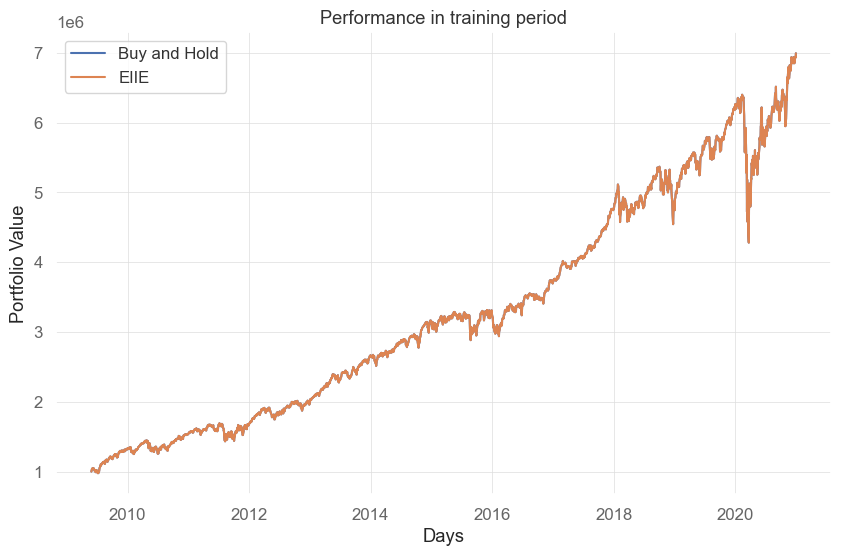

In [136]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["date"], UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["date"], EIIE_results["training"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

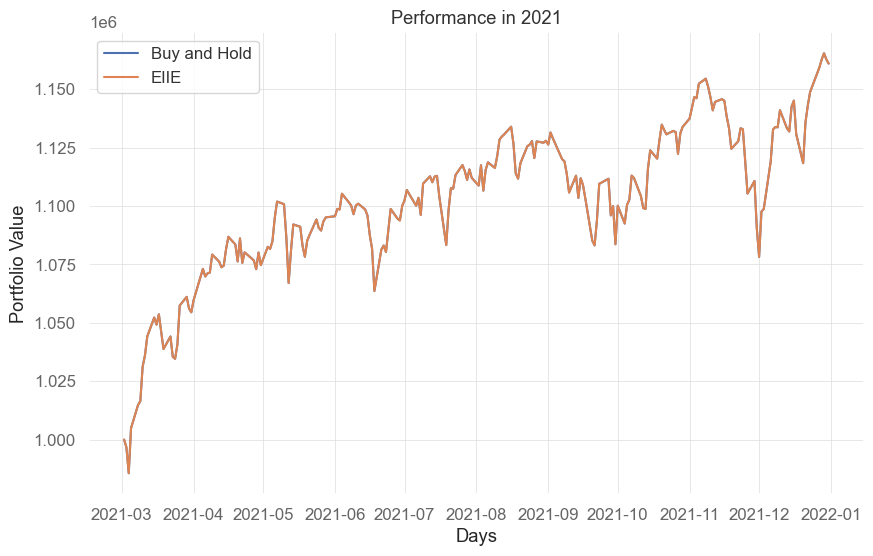

In [137]:
plt.plot(UBAH_results["2021"]["date"], UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["date"], EIIE_results["2021"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

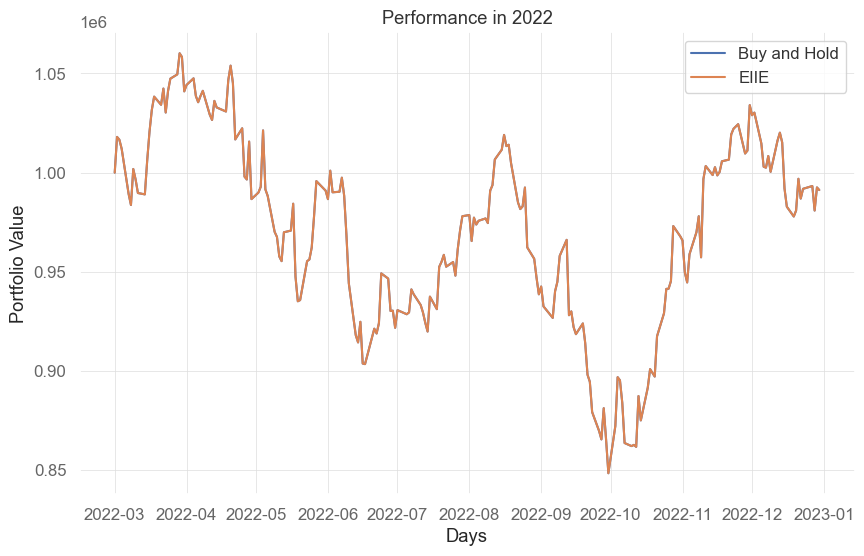

In [138]:
plt.plot(UBAH_results["2022"]["date"], UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["date"], EIIE_results["2022"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

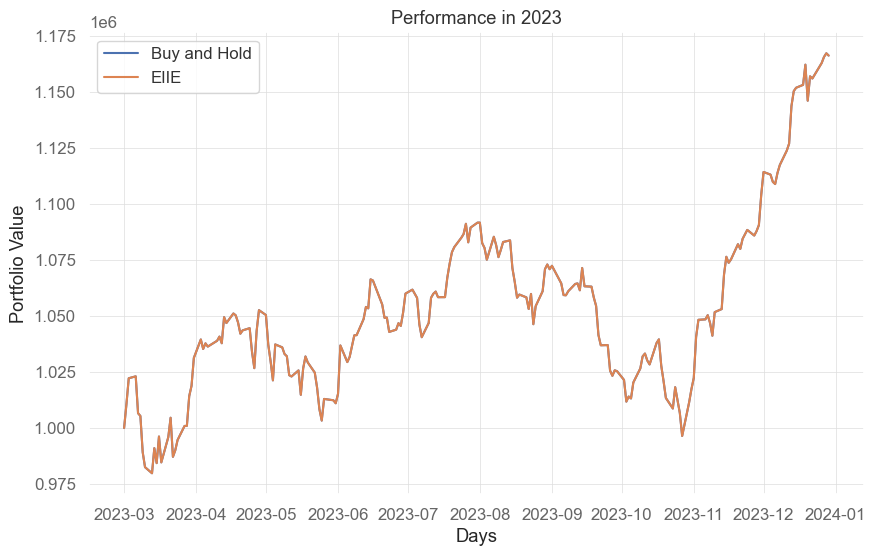

In [139]:
plt.plot(UBAH_results["2023"]["date"], UBAH_results["2023"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2023"]["date"], EIIE_results["2023"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2023")
plt.legend()

plt.show()

# TODO can I used ANOVA, or Analysis of Variance,

Compare with ANova,
Returns 
Drawdown period
And sharpe ratio